In the last module, we processed RADseq data from the red diamond rattlesnake (Crotalus ruber) to assemble it from raw reads into aligned data. We now have files that are sequences of SNPs (single nucleotide polymorphisms) or loci that are on a common coordinate system for each individual sample. This allows us to make inferences based on variation at sites in the alignment across samples. We'll do some basic population genetic analyses to look at population structure. We'll run all of this in R.



DOWNLOAD THE DATA fromt the bucket we made in the previous module

In [3]:
system("gsutil -m cp -r gs://ruber-ipyrad-out/ .", intern = TRUE)

character(0)

In [ ]:
# necessary for me on MedicineBow cluster
# .libPaths(c("/cluster/medbow/home/sharrin2/R/x86_64-pc-linux-gnu-library/4.4",
#            "/apps/u/spack/gcc/14.2.0/r/4.4.0-w7xoohc/rlib/R/library"))

In [ ]:
# uncomment for actual tutorial, commented for dev
# install.packages(c("adegenet", "plotrix", "mapdata", "BiocManager", "vcfR", "fossil", "scatterpie", "mapproj", "MASS"))
# BiocManager::install("LEA")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



This may take several minutes. Once that's done, we can load up the packages:

In [5]:
# Load up necessary packages
library(vcfR)
library(adegenet)
library(LEA)
library(mapdata)
library(ggplot2)
library(scatterpie)
library(mapproj)
library(fossil)
library(MASS)


   *****       ***   vcfR   ***       *****
   This is vcfR 1.15.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


Loading required package: ade4


   /// adegenet 2.1.10 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()



Loading required package: maps

scatterpie v0.2.4 Learn more at https://yulab-smu.top/



Loading required package: sp


Attaching package: ‘sp’


The following object is masked from ‘package:scatterpie’:

    recenter


Loading required package: shapefiles

Loading required package: foreign


Attaching package: ‘shapefiles’


The following objects are masked from ‘package:foreign’:

    read.dbf, write.dbf




Then we will specify a number of file paths and read in a few files so that we don’t have to repeatedly hardcode file paths farther down in the notebook. This makes it easier to reuse the script on different datasets or the same data with different filtering schemes without having to search through the script for every time an absolute file path is specified.

In [6]:
getwd()

[1] "/home/jupyter/RADseq_cloud_learn"

In [8]:
## Set up an object containing the path to the data
data_dir <- "/home/jupyter/RADseq_cloud_learn/ruber-ipyrad-out"

## make a directory to put the output plots into
##    this can be wherever you like, I'm putting it into the directory that contains
##    my scripts and ipyrad output directories
out_dir <- "/home/jupyter/RADseq_cloud_learn/pop_struct_out"
if(!dir.exists(out_dir)){ # check if the directory  exists and return TRUE if it does not
  dir.create(out_dir)   # create the directory if it does not exist
}

# Set up an object that contains the base file name of files in the output directory. 
#    Data files are all this basename with varying extensions
#  we won't call this 'basename' because that is a function in R
#  setting up the files this way allows us to easily run this script on another assembly 
#    without needing to edit file names everywhere they occur
basefile <- "ruber_reduced_denovo"

# Read in the geographic coordinates for plotting later
coords <- read.csv("/home/jupyter/RADseq_cloud_learn/ruber-ipyrad-out/Localities.csv", header=TRUE, row.names=NULL)



####################################################################################
## Set up paths to input files using the base file name specified above
####################################################################################
path_ugeno <- paste0(data_dir,"/", basefile,".ugeno")
path_ustr <- paste0(data_dir,"/", basefile,".ustr")
path_vcf <- paste0(data_dir,"/", basefile,".vcf")

### Set up some colors for plotting farther down
colors_2 <- c("red", "blue") # colors for plotting 2 populations


# Set the working directory to the output directory
setwd(out_dir) # set directory as the output directory

## Basic stats

Let's start by reading in the data and calculating some very basic population genetic summary statistics.

Read in the data from the vcf file:

In [9]:
gendata_all <- read.vcfR(path_vcf) # read in all of the genetic data from the vcf file
gendata <- vcfR2genind(gendata_all) # convert to genind format

Scanning file to determine attributes.
File attributes:
  meta lines: 10
  header_line: 11
  variant count: 2885
  column count: 42
Meta line 10 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 2885
  Character matrix gt cols: 42
  skip: 0
  nrows: 2885
  row_num: 0
Processed variant: 2885
All variants processed


Calculate observed and expected heterozygosity:


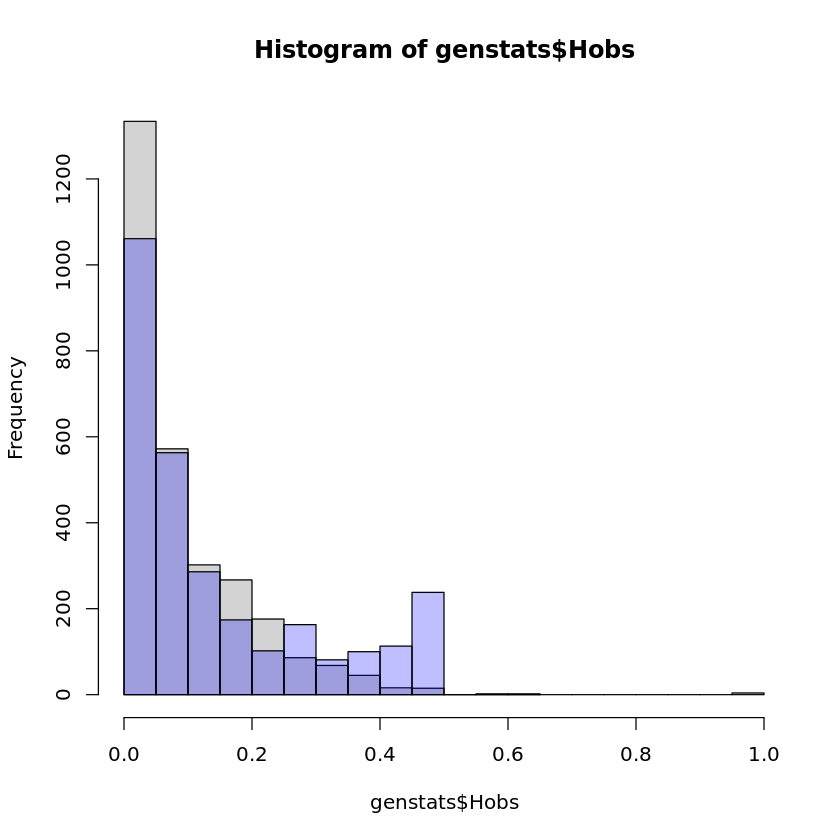

In [10]:
# Use adegenet's summary function on the genind object
genstats <- summary(gendata)

# and make overlapping histograms
hist(genstats$Hobs, breaks = 15)
hist(genstats$Hexp, add = TRUE, col = scales::alpha('blue',.25))

Looks like we might have lower observed than expected heterozygosity. Let's check the means across loci to confirm:

In [11]:
# and look at the mean of each
mean(genstats$Hobs)
mean(genstats$Hexp)

[1] 0.09911455

[1] 0.1528145

Yep, we have low observed heterozygosity compared to expected. One likely reason for this is if there is population structure in the data. We'll test for this shortly.

## Principal components analysis


Principal coordinates analysis, or PCA, is a common dimensionality reduction method to see how data cluster without assigning groups or number of groups a priori. We can apply this method to genetic as well as other types of data. We'll follow [documentation from the adegenet package to run PCA on our data](https://adegenet.r-forge.r-project.org/files/PRstats/practical-MVAintro.1.0.pdf):


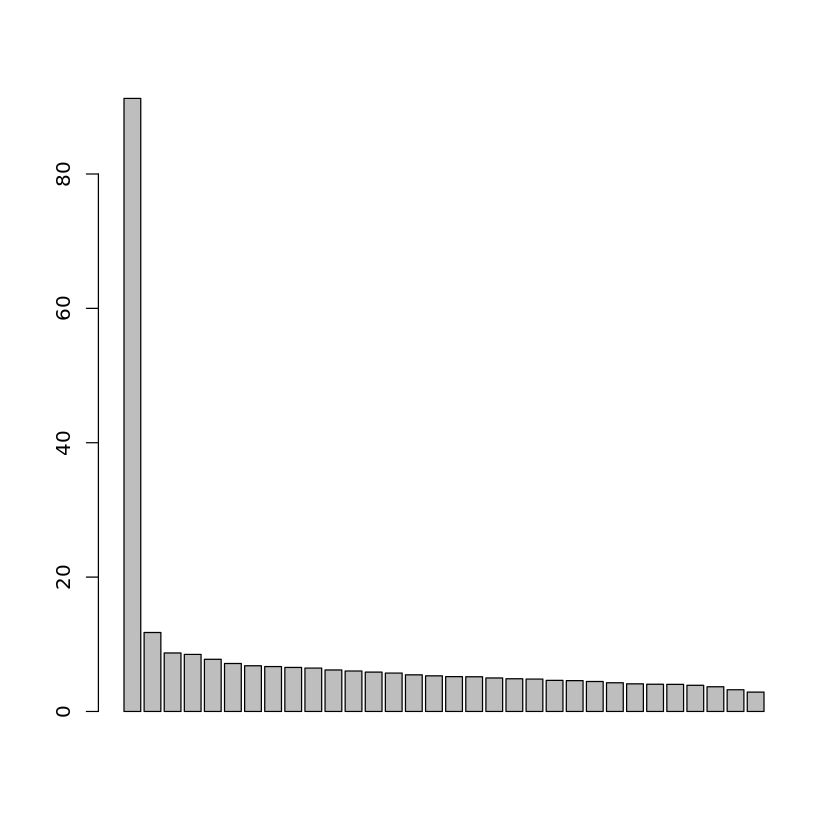

In [12]:
# calculate allele frequencies and replace NAs
genfreq <- tab(gendata, freq=TRUE, NA.method="mean")

# Run PCA
pca_res <- dudi.pca(genfreq, center = TRUE, scale = FALSE, scannf = FALSE, nf = 0)

# plot eigenvalues
barplot(pca_res$eig)

The eigenvalues (height of the bars) for each of these compnents roughly corresponds to the amount of genetic variation explained by each principal component. General advice is to retain all components before they drop off sharply. We need to retain at least 2 to make the plots we want, so let's re-run our PCA keeping 2 axes and then plot it out.

- Note that if you are running R somewhere other than a Jupyter notebook, like RStudio, you can run `pca_res <- dudi.pca(genfreq, center=TRUE, scale=FALSE)`  and it will show you a plot of the eigenvalues and ask you how many axes you want to retain interactively.

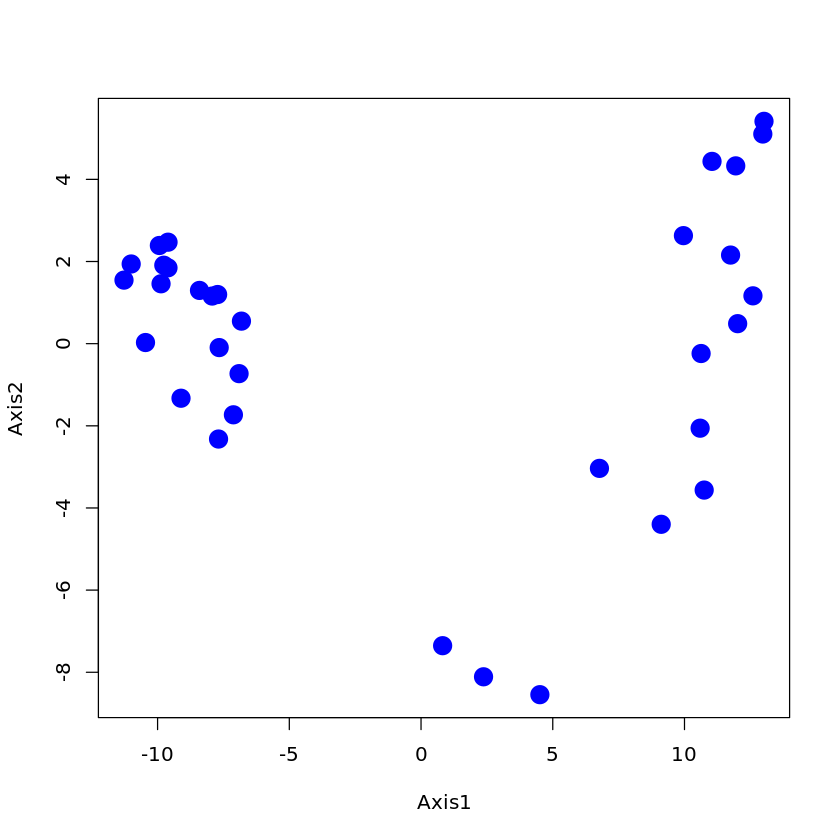

In [13]:
# Run PCA retaining only 2 axes
pca_res <- dudi.pca(df = genfreq, center = TRUE, scale = FALSE, scannf = FALSE, nf = 2)

# plot it out
plot(pca_res$li, pch = 19, cex = 2, col = "blue")

Looks like we probably have 2 distinct populations with some admixed individuals in between them. Next, we'll run a population clustering method to test this.


<br>
<br>
<br>

## Population structure using sNMF

Population assignment is a critical step in many population genetic and phylogeographic studies. Most downstream methods for estimating gene flow, divergence, population size, and other interesting population parameters require populations to be specified by you. If you have population structure in your data that you have not adequately accounted for, this can bias many types of analyses. E.g., if you try to estimate the history of population size changes in a group of samples that you assume are a single population when they actually come from multiple discrete populations, this will bias your results.

There are multiple ways to assign individuals to discrete populations. In some cases, you may have a priori ideas about population boundaries based on geographic discontinuities, differences in morphology across a species range, previous genetic data, or other sources of information. However, most of the time you will want to infer the number of populations and population membership of individuals directly from your data. This is essentially a classification problem: we are seeking to classify our whole set of genetic samples into a number of populations, often while also seeking to determine how many populations are present.

One of the most commonly used programs for the inference of population structure is the aptly named program [Structure](https://web.stanford.edu/group/pritchardlab/structure.html). Structure is a model-based clustering method that seeks to split individuals into clusters such that linkage disequilibrium is minimized and Hardy-Weinberg equilibrium is maximized within each cluster. Structure is a Bayesian method that relies on Markov chain Monte Carlo (MCMC) sampling, and can thus become somewhat unwieldy with large datasets. Many fast alternatives have been developed since the advent of Structure, including [Admixture](https://dalexander.github.io/admixture/) which utilizes the same model from Structure, but in a faster maximum likelihood implementation. Other alternative approaches do not explicitly model Hardy-Weinberg equilibrium or linkage disequilibrium, including the sNMF appraoch implemented in the [pLEA R package](http://membres-timc.imag.fr/Olivier.Francois/LEA/files/LEA_github.pdf) and DAPC as implemented in the [Adegenet R package](https://github.com/thibautjombart/adegenet). All of these methods often produce comparable results, which are often visualized as barplots of the estimated membership of each sample in one or more population clusters or as pie charts of the same information plotted onto a map as show in the figures below.

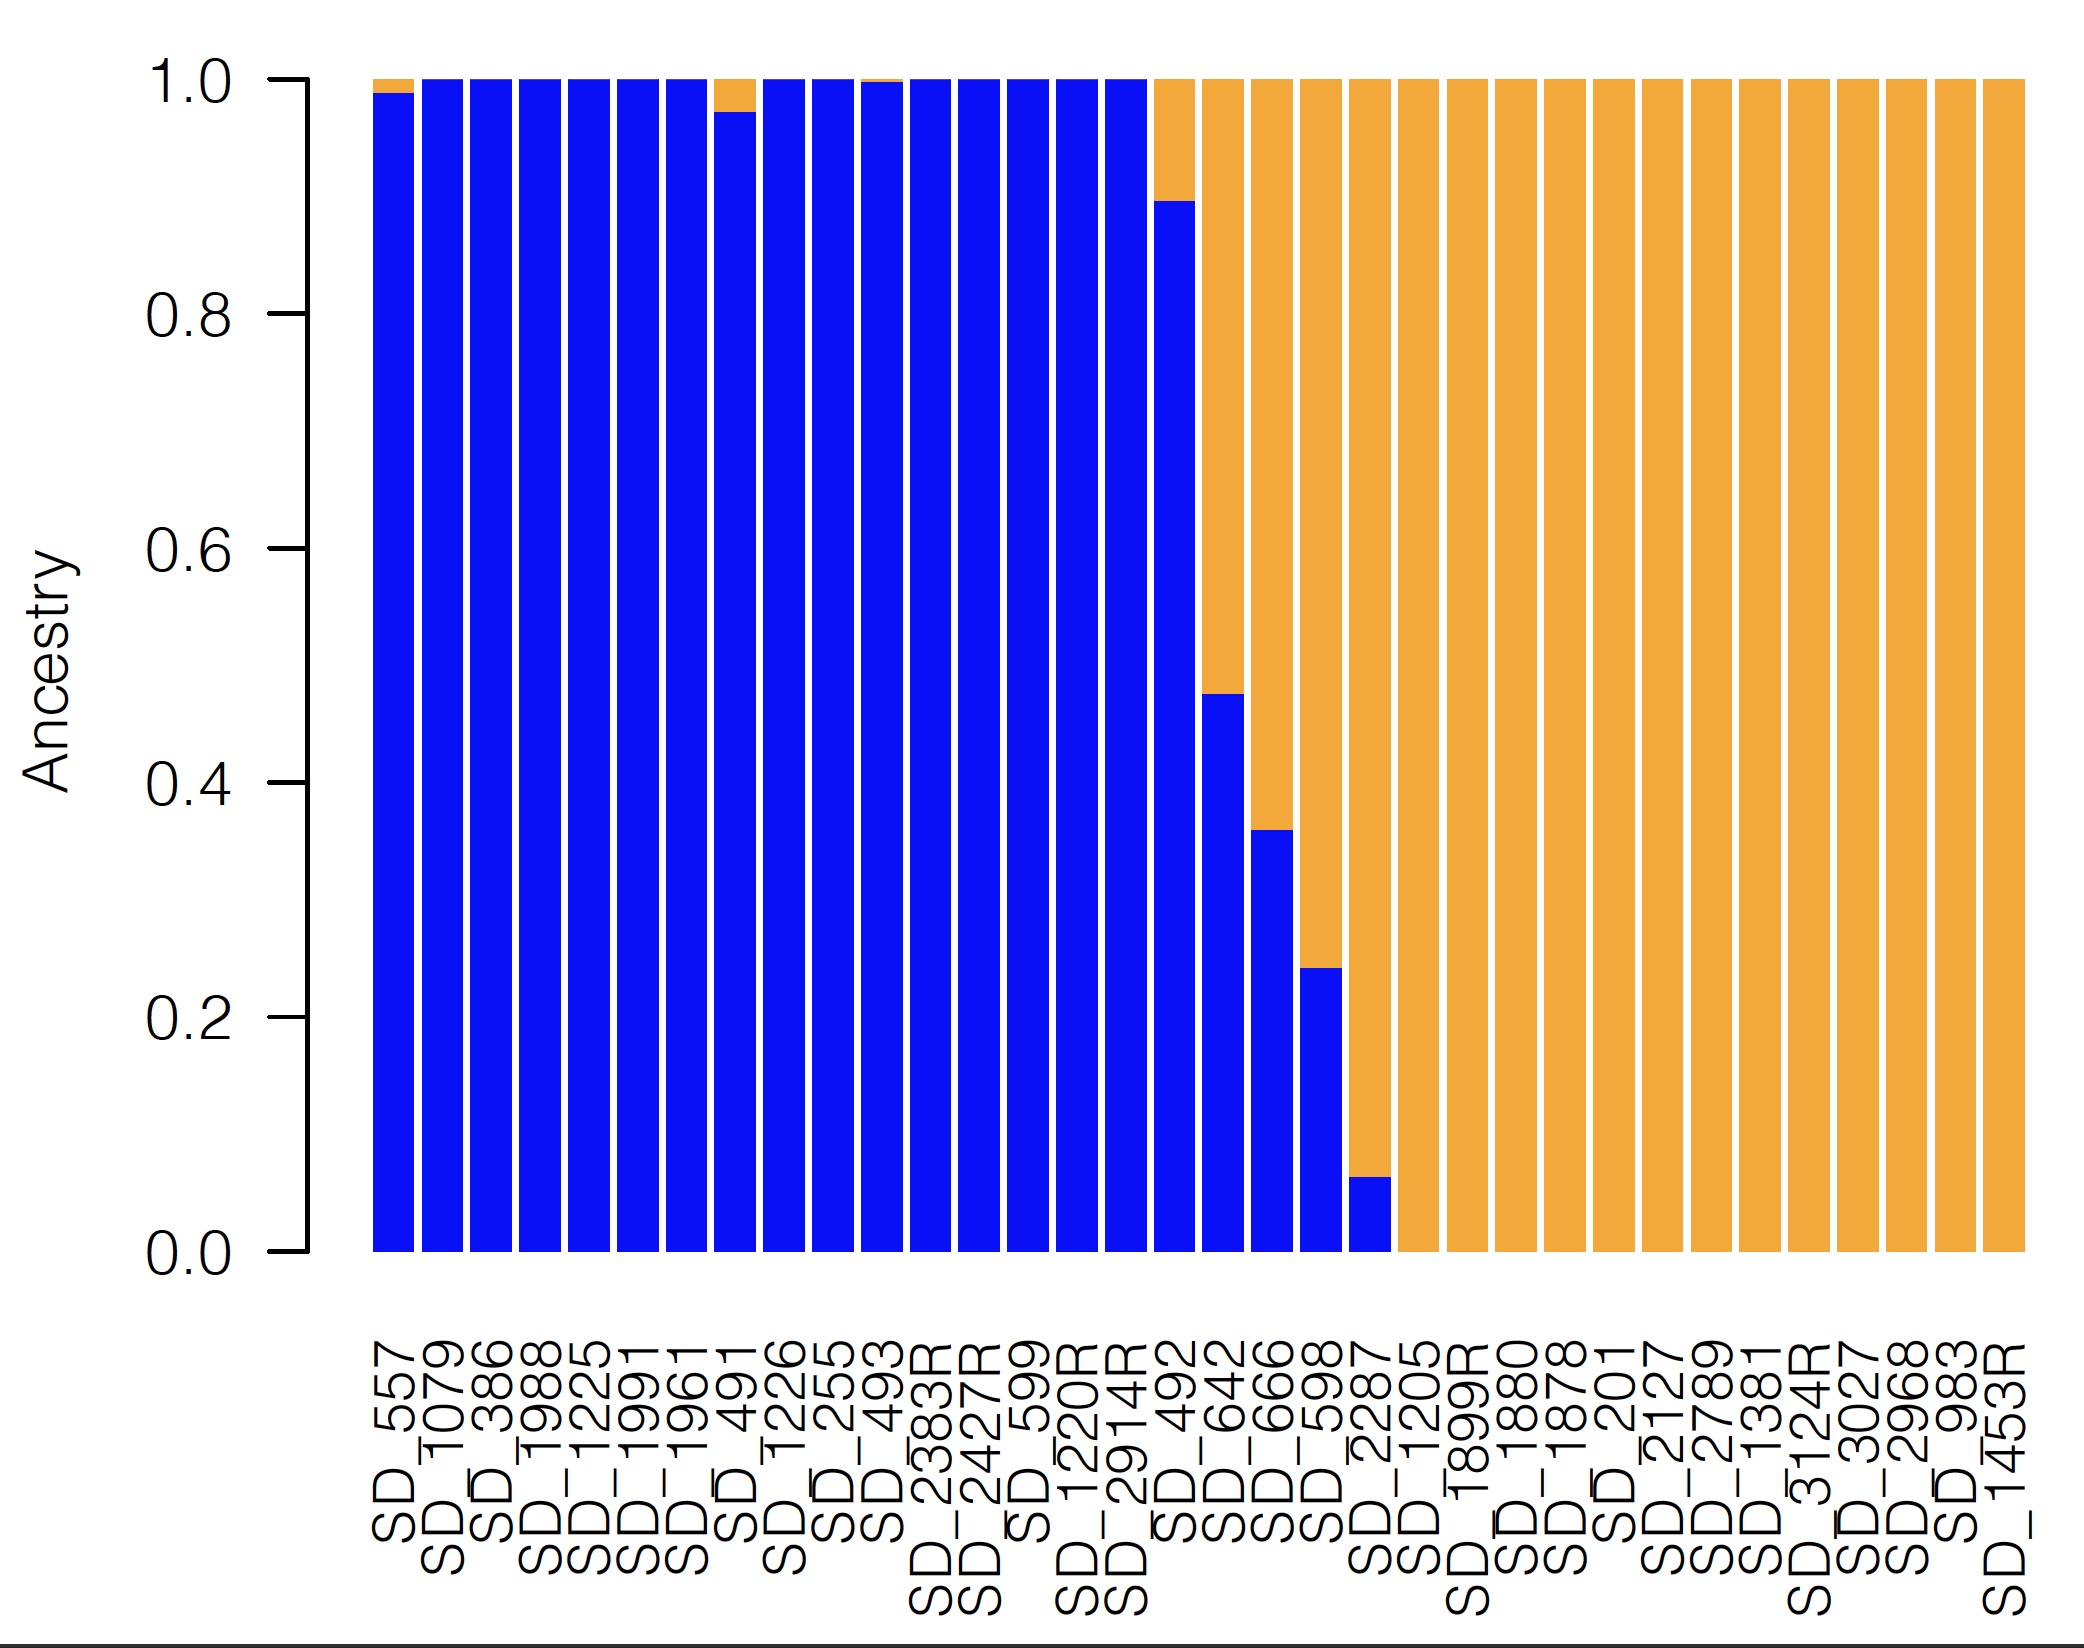
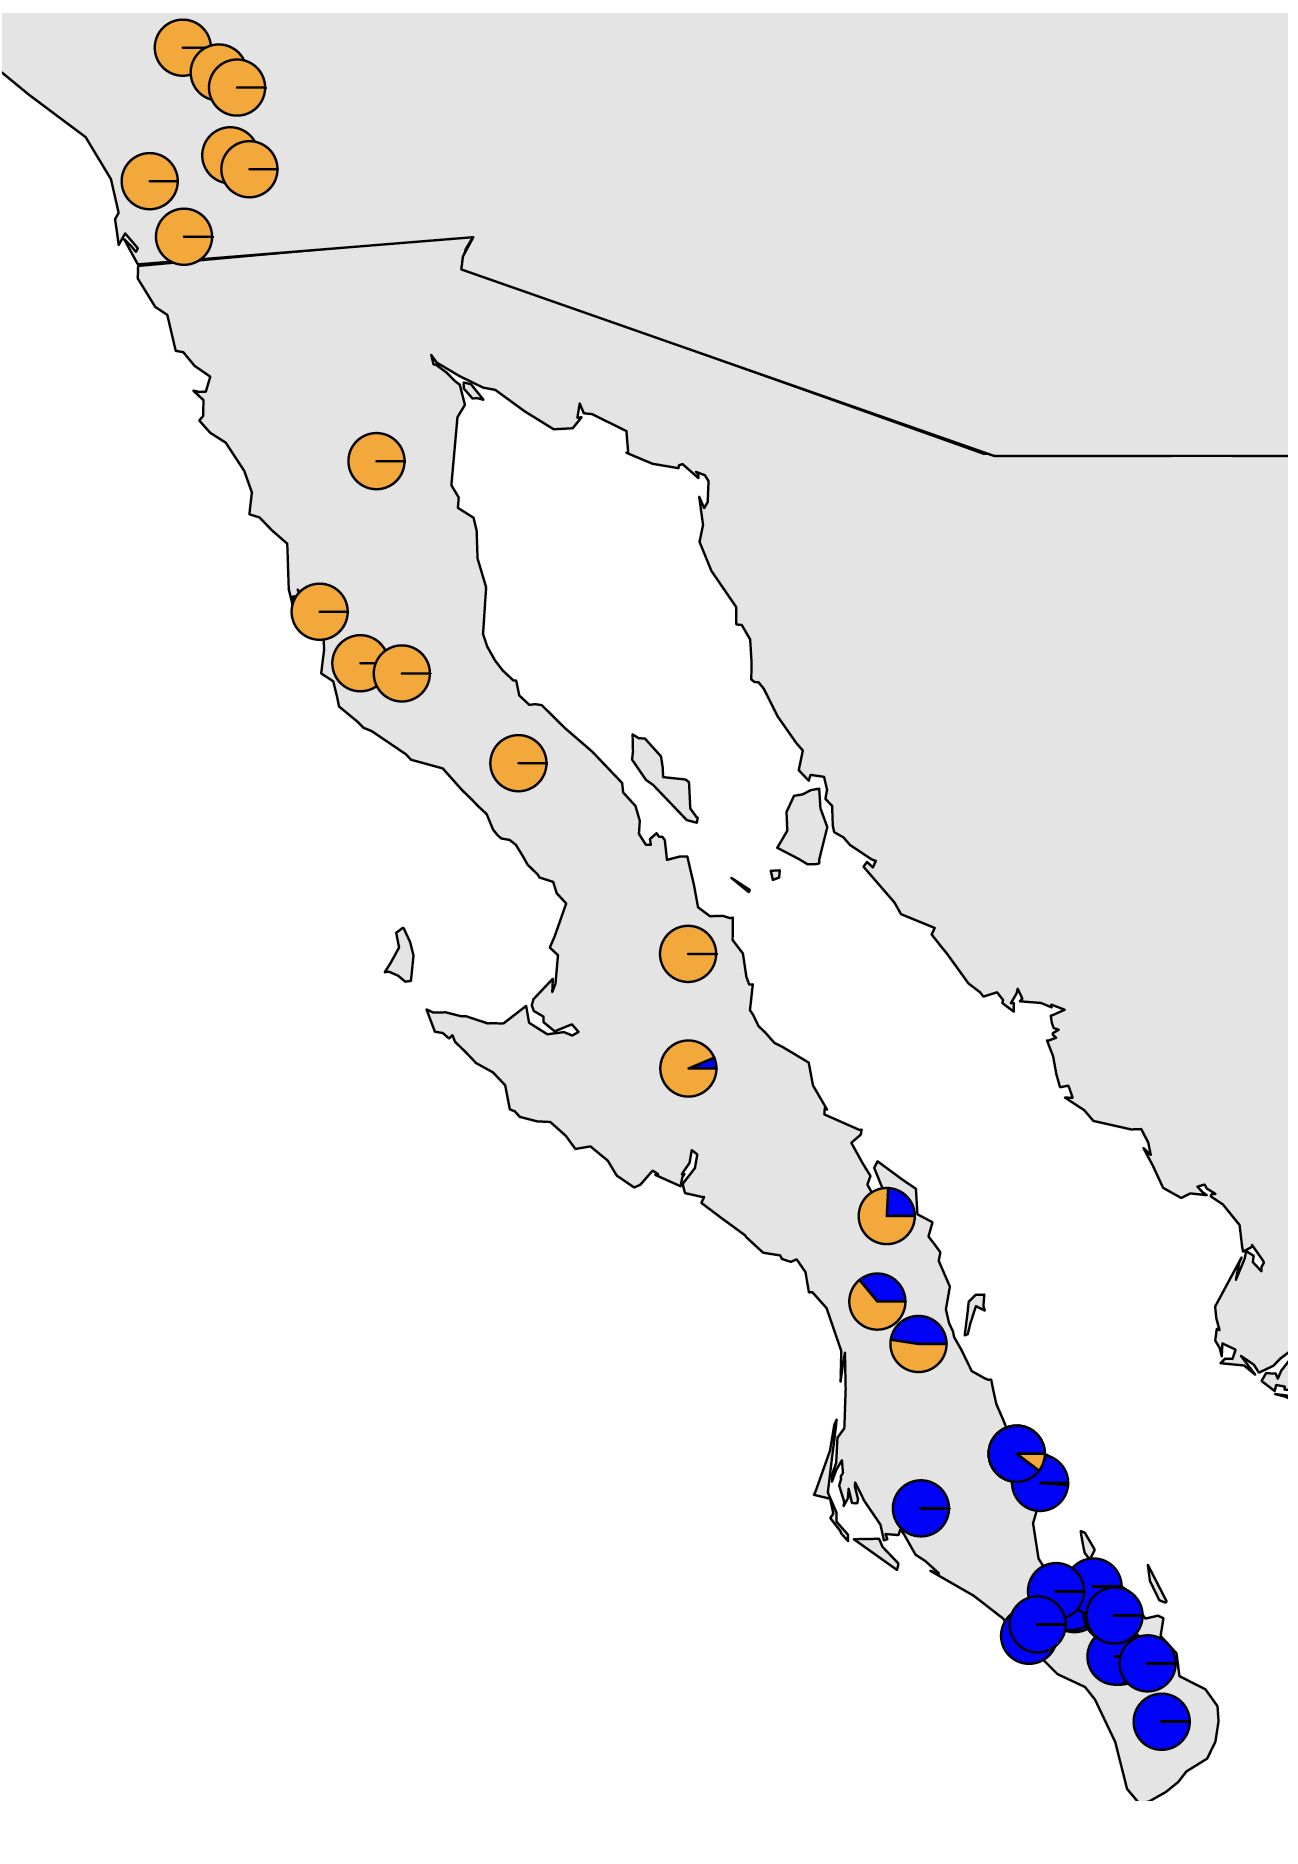



<br>

If using DAPC to estimate population membership, it is important to note that in my experience, with large amounts of data, DAPC is very good at estimating which population a sample belongs to, but if a sample is admixed, it will be confidently placed into the population that it shares the most ancestry with. Barplots or pie charts of DAPC reflect the uncertainty in classification rather than amount of admixture, so care should be taken not to interpret DAPC plots the same way as plots from Strucure, Admixture, sNMF, etc.

I like to use sNMF rather than Structure because it's very fast and produces results highly similar to Structure. sNMF can have trouble with samples that have high amounts of missing data, though, with high missing data causing individuals to appear to be admixed. In such cases, the estimates of admixture that you get out of Structure or Admixture may be better than those from sNMF.

The snmf function requires a geno file as input, and requires that it has the extension .geno. We want to use only unlinked SNPs here (i.e., 1 SNP per RAD locus, assumed to be unlinked), and the geno file of unlinked snps from ipyrad has the extension ugeno, so we'll copy the file and give it a new extension:

In [14]:
# Use a regular expression substitution to generate the new file name
path_geno<-gsub(".ugeno", ".u.geno", path_ugeno)

file.copy(path_ugeno, path_geno) # do the copying with the new name

[1] TRUE

Now we’re ready to run sNMF. We’ll run this using 1 to 10 possible ancestral populations and evaluate the fit of these different numbers of populations (referred to as k values) to the data using the cross entropy criterion:


## EDIT NUM CPUs as desired here:

In [18]:
sink(tempfile()) # set the screen output to write to a temp file so that the notebook doesn't get too gummed up - delete to see all screen messages generated by sNMF
obj.at <- snmf(input.file = path_geno,  # input file is the .geno format file
               K = 1:10, # we will test for k=1 through 10
               ploidy = 2, 
               entropy = T, # use the cross entropy criterion for assessing the best k 
               repetitions = 10, # Run 10 independent replicate analyses
               CPU = 8, 
               project = "new", tolerance = 0.00001, iterations = 500)
sink()

Let’s make a plot of the cross-entropy plot

In [ ]:
plot(obj.at, col = "lightblue", cex = 1.2, pch = 19)

# We could alternately plot this to pdf:
pdf("snmf_cross_ent.pdf", width = 8, height=5)
plot(obj.at, col = "lightblue", cex = 1.2, pch = 19)
dev.off()

You should see that the best fit model is one with 2 populations, as shown by the lowest cross-entropy score. We can also look at a numeric summary of this result:

In [ ]:
outstats <- summary(obj.at)
outstats

We can also confirm cross entropy values for K are consistent across runs and get the single best run for K=2.


In [ ]:
ce <- cross.entropy(obj.at, K = 2) 
ce # pretty similar
best.run <- which.min(ce) # find the run with the lowest cross validation error


Then we can get the snmf Q matrix from the best run at the best k, which is a matrix of the proportion of ancestry that each sample derives from each population.

In [ ]:
qmatrix <- Q(obj.at, K = 2, run = best.run)
admix<-as.data.frame(qmatrix)

This will let us plot out these proportions to a map, which we'll do next with a little additional setup.

## Plot population clusters to a map


Start by sorting out the coordinates of each individual into the same order as the individuals in the genetic data and make sure that there is gepgraphic data for each individual in the genetic data



In [ ]:
# Get individual names for the genetic data from the vcf file, read in as gendata above - individuals will be in the same order in all genetic data files output by ipyrad



ind_names[which(!ind_names %in% coords[,"Field.No."])] # check if there are any individuals not in the coordinates
# match up the coordinates to the order of the individuals from snmf
match_coords<-match(ind_names, coords[,"Field.No."])
snmf_coords<-coords[match_coords,]

# get the coordinate and admix data into a single dataframe to plot out these proportions on a map
for_pies <- cbind(snmf_coords, admix)

In [ ]:
rownames(gendata@tab)